In [1]:
!nvidia-smi

Mon Sep  4 11:27:29 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.99                 Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0              15W /  50W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [3]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [4]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [5]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode='categorical',
                                                                           batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [7]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[7.28571415e+00 8.28571415e+00 1.22857151e+01]
   [6.71428537e+00 7.71428537e+00 1.17142859e+01]
   [3.57142878e+00 4.57142878e+00 7.58163261e+00]
   ...
   [1.50775497e+02 1.39627594e+02 1.06357208e+02]
   [1.48979568e+02 1.37979568e+02 1.05979561e+02]
   [1.37382370e+02 1.26382378e+02 9.43823776e+01]]

  [[5.66836739e+00 6.66836739e+00 1.05255108e+01]
   [5.93367338e+00 6.93367338e+00 8.93367386e+00]
   [5.19897985e+00 6.21428585e+00 8.16836739e+00]
   ...
   [1.51071518e+02 1.40428726e+02 1.05627686e+02]
   [1.53852020e+02 1.43852020e+02 1.08852028e+02]
   [1.48908066e+02 1.37979492e+02 1.05765205e+02]]

  [[7.06632614e+00 8.06632614e+00 1.00663261e+01]
   [5.07142830e+00 6.07142830e+00 8.07142830e+00]
   [4.21428585e+00 6.04591846e+00 5.55102062e+00]
   ...
   [1.52500092e+02 1.41857300e+02 1.06239929e+02]
   [1.55158127e+02 1.45158127e+02 1.10158127e+02]
   [1.50775528e+02 1.40775528e+02 1.05775528e+02]]

  ...

  [[1.02142868e+02 1.01142868e+02 8.31428680e+01]
   [1

In [9]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='Input_Layer')

# Resnet50V2 --> x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = base_model(inputs) # <-- ElasticnetV2B0
print('Shape Of base Model: \t {}'.format(x.shape))

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print('Shape After GlobalAveragePooling2D(): \t {}'.format(x.shape))

outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

Shape Of base Model: 	 (None, 7, 7, 1280)
Shape After GlobalAveragePooling2D(): 	 (None, 1280)


In [10]:
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 callbacks=[create_tensorboard_callback('transfer_learning', '10_percent_features_extract')])

Saving TensorBoard log files to: transfer_learning/10_percent_features_extract/20230904-112741
Epoch 1/5
24/24 [==============================] - 24s 333ms/step - loss: 1.9147 - accuracy: 0.4147 - val_loss: 1.3407 - val_accuracy: 0.7155
Epoch 2/5
24/24 [==============================] - 5s 199ms/step - loss: 1.1657 - accuracy: 0.7347 - val_loss: 0.9358 - val_accuracy: 0.7796
Epoch 3/5
24/24 [==============================] - 5s 196ms/step - loss: 0.8411 - accuracy: 0.8173 - val_loss: 0.7089 - val_accuracy: 0.8289
Epoch 4/5
24/24 [==============================] - 5s 192ms/step - loss: 0.7061 - accuracy: 0.8400 - val_loss: 0.6229 - val_accuracy: 0.8405
Epoch 5/5
24/24 [==============================] - 5s 192ms/step - loss: 0.6061 - accuracy: 0.8507 - val_loss: 0.5527 - val_accuracy: 0.8618


In [11]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 9s 108ms/step - loss: 0.5766 - accuracy: 0.8556


[0.5765636563301086, 0.8555999994277954]

In [12]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [13]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

                                                                                                  
 block3b_expand_bn (BatchNormal  (None, None, None,   768        ['block3b_expand_conv[0][0]']    
 ization)                       192)                                                              
                                                                                                  
 block3b_expand_activation (Act  (None, None, None,   0          ['block3b_expand_bn[0][0]']      
 ivation)                       192)                                                              
                                                                                                  
 block3b_project_conv (Conv2D)  (None, None, None,   9216        ['block3b_expand_activation[0][0]
                                48)                              ']                               
                                                                                                  
 block3b_p

                                384)                              'block4b_se_expand[0][0]']      
                                                                                                  
 block4b_project_conv (Conv2D)  (None, None, None,   36864       ['block4b_se_excite[0][0]']      
                                96)                                                               
                                                                                                  
 block4b_project_bn (BatchNorma  (None, None, None,   384        ['block4b_project_conv[0][0]']   
 lization)                      96)                                                               
                                                                                                  
 block4b_drop (Dropout)         (None, None, None,   0           ['block4b_project_bn[0][0]']     
                                96)                                                               
          

 block5a_se_excite (Multiply)   (None, None, None,   0           ['block5a_activation[0][0]',     
                                576)                              'block5a_se_expand[0][0]']      
                                                                                                  
 block5a_project_conv (Conv2D)  (None, None, None,   64512       ['block5a_se_excite[0][0]']      
                                112)                                                              
                                                                                                  
 block5a_project_bn (BatchNorma  (None, None, None,   448        ['block5a_project_conv[0][0]']   
 lization)                      112)                                                              
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, None, None,   75264       ['block5a_project_bn[0][0]']     
          

                                                                                                  
 block5c_project_bn (BatchNorma  (None, None, None,   448        ['block5c_project_conv[0][0]']   
 lization)                      112)                                                              
                                                                                                  
 block5c_drop (Dropout)         (None, None, None,   0           ['block5c_project_bn[0][0]']     
                                112)                                                              
                                                                                                  
 block5c_add (Add)              (None, None, None,   0           ['block5c_drop[0][0]',           
                                112)                              'block5b_add[0][0]']            
                                                                                                  
 block5d_e

                                112)                                                              
                                                                                                  
 block5e_project_bn (BatchNorma  (None, None, None,   448        ['block5e_project_conv[0][0]']   
 lization)                      112)                                                              
                                                                                                  
 block5e_drop (Dropout)         (None, None, None,   0           ['block5e_project_bn[0][0]']     
                                112)                                                              
                                                                                                  
 block5e_add (Add)              (None, None, None,   0           ['block5e_drop[0][0]',           
                                112)                              'block5d_add[0][0]']            
          

 block6b_drop (Dropout)         (None, None, None,   0           ['block6b_project_bn[0][0]']     
                                192)                                                              
                                                                                                  
 block6b_add (Add)              (None, None, None,   0           ['block6b_drop[0][0]',           
                                192)                              'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, None, None,   221184      ['block6b_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, None, None,   4608       ['block6c_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block6d_drop (Dropout)         (None, None, None,   0           ['block6d_project_bn[0][0]']     
                                192)                                                              
                                                                                                  
 block6d_add (Add)              (None, None, None,   0           ['block6d_drop[0][0]',           
                                192)                              'block6c_add[0][0]']            
                                                                                                  
 block6e_expand_conv (Conv2D)   (None, None, None,   221184      ['block6d_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6e_e

 lization)                      192)                                                              
                                                                                                  
 block6f_drop (Dropout)         (None, None, None,   0           ['block6f_project_bn[0][0]']     
                                192)                                                              
                                                                                                  
 block6f_add (Add)              (None, None, None,   0           ['block6f_drop[0][0]',           
                                192)                              'block6e_add[0][0]']            
                                                                                                  
 block6g_expand_conv (Conv2D)   (None, None, None,   221184      ['block6f_add[0][0]']            
                                1152)                                                             
          

 block6h_project_bn (BatchNorma  (None, None, None,   768        ['block6h_project_conv[0][0]']   
 lization)                      192)                                                              
                                                                                                  
 block6h_drop (Dropout)         (None, None, None,   0           ['block6h_project_bn[0][0]']     
                                192)                                                              
                                                                                                  
 block6h_add (Add)              (None, None, None,   0           ['block6h_drop[0][0]',           
                                192)                              'block6g_add[0][0]']            
                                                                                                  
 top_conv (Conv2D)              (None, None, None,   245760      ['block6h_add[0][0]']            
          

In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


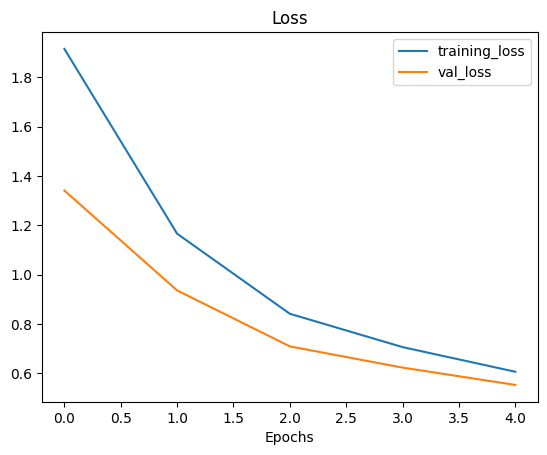

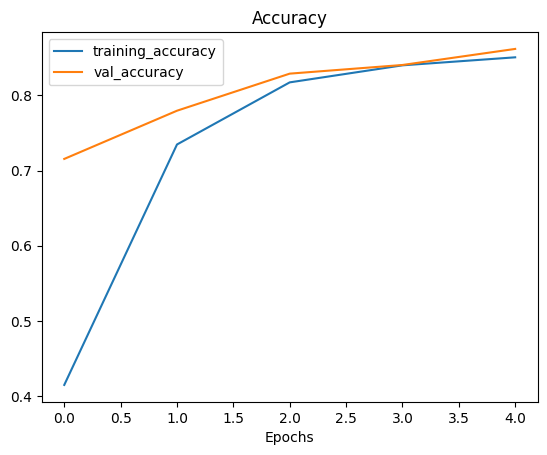

In [15]:
plot_loss_curves(history_10_percent)

In [16]:
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [17]:
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [18]:
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [19]:
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [20]:
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [21]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [22]:
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [23]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2) # ,preprocessing.Rescaling(1./255) <-- ResNet50V2
], name ="data_augmentation")

Text(0.5, 1.0, 'Augmented random image from class: sushi')

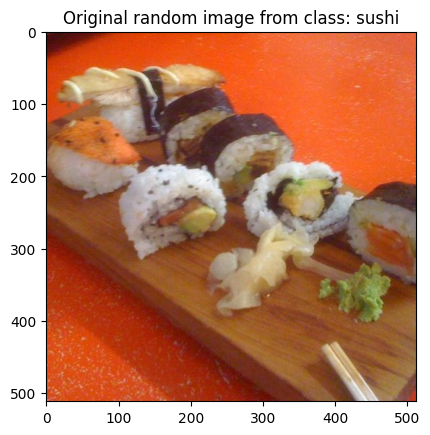

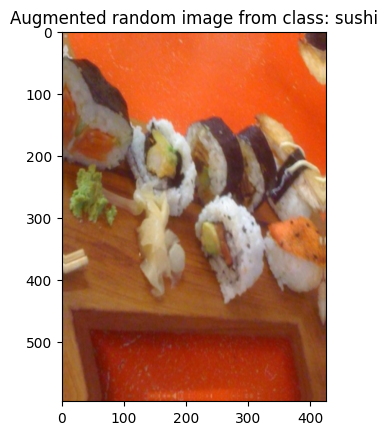

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")

augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training = True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")

In [25]:
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)

In [26]:
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [27]:
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)),
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230904-112844
Epoch 1/5
3/3 [==============================] - 22s 4s/step - loss: 2.3854 - accuracy: 0.0714 - val_loss: 2.2737 - val_accuracy: 0.1250
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.0953 - accuracy: 0.2286 - val_loss: 2.1434 - val_accuracy: 0.2188
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.8998 - accuracy: 0.4571 - val_loss: 2.0303 - val_accuracy: 0.3273
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.7014 - accuracy: 0.5429 - val_loss: 1.9411 - val_accuracy: 0.4062
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.5502 - accuracy: 0.7143 - val_loss: 1.8674 - val_accuracy: 0.4293


In [28]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [29]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 10s 121ms/step - loss: 1.8406 - accuracy: 0.4620


[1.8406232595443726, 0.4620000123977661]

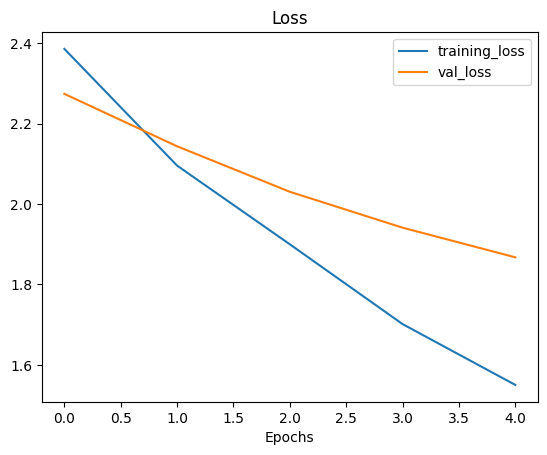

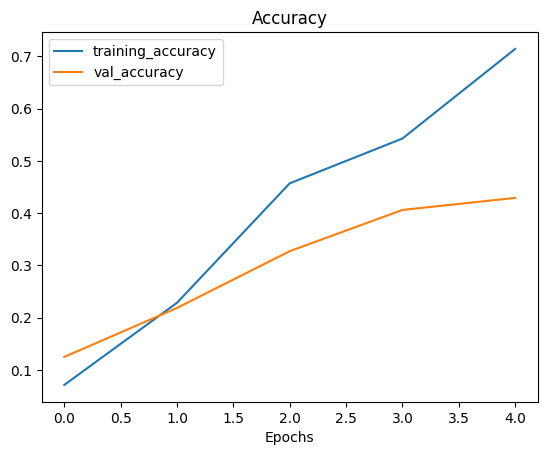

In [30]:
plot_loss_curves(history_1_percent)

In [31]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [32]:
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [33]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2) # ,preprocessing.Rescaling(1./255) <-- ResNet50V2
], name ="data_augmentation")

In [34]:
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

In [35]:
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

In [36]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [37]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

In [38]:
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230904-112942
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0271 - accuracy: 0.3173
Epoch 1: val_loss improved from inf to 1.47469, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 35s 981ms/step - loss: 2.0271 - accuracy: 0.3173 - val_loss: 1.4747 - val_accuracy: 0.6678
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3181 - accuracy: 0.7147
Epoch 2: val_loss improved from 1.47469 to 1.02215, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 22s 894ms/step - loss: 1.3181 - accuracy: 0.7147 - val_loss: 1.0222 - val_accuracy: 0.7845
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9996 - accuracy: 0.7800
Epoch 3: val_loss improved from 1.02215 to 0.80930, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [=

In [39]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 10s 118ms/step - loss: 0.6384 - accuracy: 0.8372


[0.6384305357933044, 0.8371999859809875]

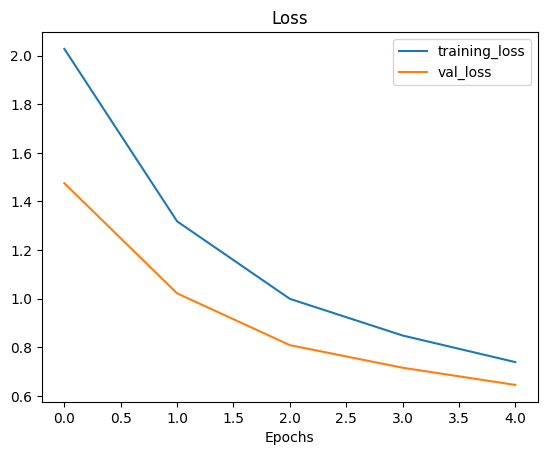

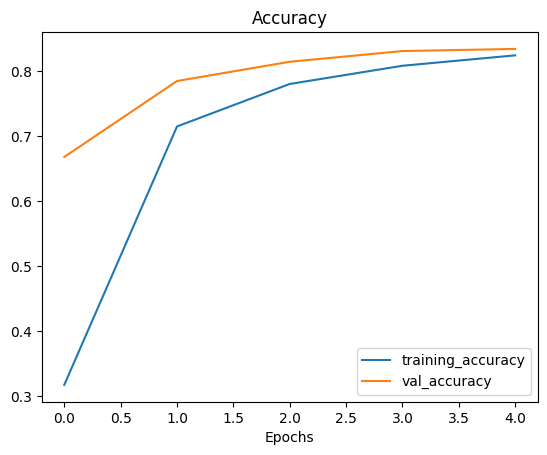

In [40]:
plot_loss_curves(history_10_percent_data_aug)

In [41]:
model_2.load_weights(checkpoint_path)

In [42]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 10s 118ms/step - loss: 0.6384 - accuracy: 0.8372


In [43]:
results_10_percent_data_aug == loaded_weights_model_results

False

In [44]:
results_10_percent_data_aug

[0.6384305357933044, 0.8371999859809875]

In [45]:
loaded_weights_model_results

[0.6384304761886597, 0.8371999859809875]

In [46]:
import numpy as np

np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [47]:
np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results)

array([5.96046448e-08, 0.00000000e+00])

In [48]:
model_2.layers

In [51]:
for layer in model_2.layers:
    print(layer,'\n',layer.trainable,'\n \n')

 True 
 

 True 
 

 False 
 

 True 
 

 True 
 



In [53]:
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, '\t', layer.name, '\t', layer.trainable)

0 	 input_3 	 False
1 	 rescaling_3 	 False
2 	 normalization_2 	 False
3 	 rescaling_4 	 False
4 	 stem_conv_pad 	 False
5 	 stem_conv 	 False
6 	 stem_bn 	 False
7 	 stem_activation 	 False
8 	 block1a_dwconv 	 False
9 	 block1a_bn 	 False
10 	 block1a_activation 	 False
11 	 block1a_se_squeeze 	 False
12 	 block1a_se_reshape 	 False
13 	 block1a_se_reduce 	 False
14 	 block1a_se_expand 	 False
15 	 block1a_se_excite 	 False
16 	 block1a_project_conv 	 False
17 	 block1a_project_bn 	 False
18 	 block2a_expand_conv 	 False
19 	 block2a_expand_bn 	 False
20 	 block2a_expand_activation 	 False
21 	 block2a_dwconv_pad 	 False
22 	 block2a_dwconv 	 False
23 	 block2a_bn 	 False
24 	 block2a_activation 	 False
25 	 block2a_se_squeeze 	 False
26 	 block2a_se_reshape 	 False
27 	 block2a_se_reduce 	 False
28 	 block2a_se_expand 	 False
29 	 block2a_se_excite 	 False
30 	 block2a_project_conv 	 False
31 	 block2a_project_bn 	 False
32 	 block2b_expand_conv 	 False
33 	 block2b_expand_bn 	 Fal

In [54]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [55]:
print(len(model_2.layers[2].trainable_variables))

0


In [56]:
print(len(base_model.trainable_variables))

0


In [57]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False
    
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [59]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-train

In [60]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [61]:
print(len(model_2.trainable_variables))

12


In [62]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230904-114903
Epoch 5/10
24/24 [==============================] - 34s 805ms/step - loss: 0.5898 - accuracy: 0.8373 - val_loss: 0.4977 - val_accuracy: 0.8421
Epoch 6/10
24/24 [==============================] - 17s 721ms/step - loss: 0.4673 - accuracy: 0.8747 - val_loss: 0.4575 - val_accuracy: 0.8388
Epoch 7/10
24/24 [==============================] - 18s 740ms/step - loss: 0.4280 - accuracy: 0.8747 - val_loss: 0.4364 - val_accuracy: 0.8470
Epoch 8/10
24/24 [==============================] - 15s 619ms/step - loss: 0.3800 - accuracy: 0.8867 - val_loss: 0.4417 - val_accuracy: 0.8438
Epoch 9/10
24/24 [==============================] - 16s 688ms/step - loss: 0.3402 - accuracy: 0.9080 - val_loss: 0.4320 - val_accuracy: 0.8470
Epoch 10/10
24/24 [==============================] - 16s 649ms/step - loss: 0.2854 - accuracy: 0.9267 - val_loss: 0.4608 - val_accuracy: 0.8339


In [63]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 10s 125ms/step - loss: 0.4327 - accuracy: 0.8532


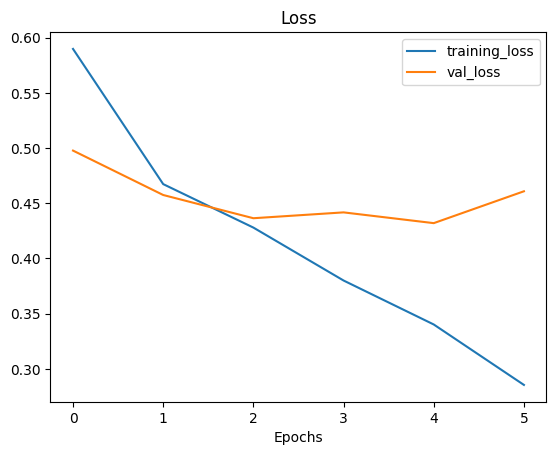

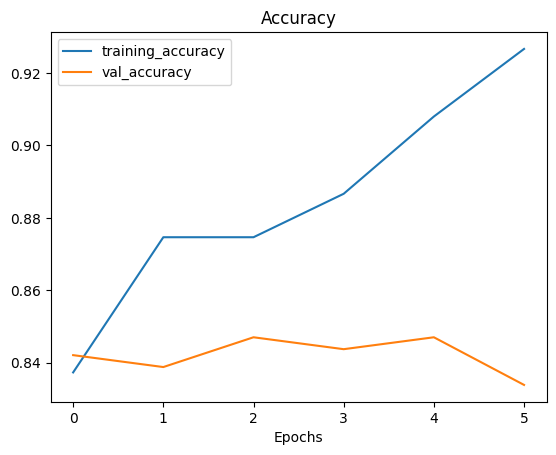

In [66]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [64]:
def compare_historys(original_history, new_history, initial_epochs=5):

    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3173333406448364, 0.7146666646003723, 0.7799999713897705, 0.8080000281333923, 0.8240000009536743, 0.8373333215713501, 0.874666690826416, 0.874666690826416, 0.8866666555404663, 0.9079999923706055, 0.9266666769981384]


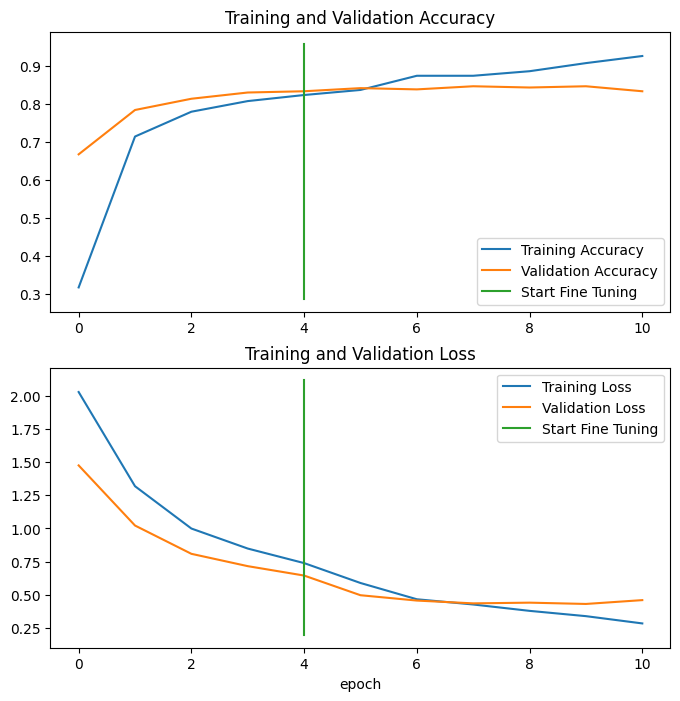

In [65]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

In [67]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [68]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [69]:
IMG_SIZE = (224, 224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [70]:
model_2.evaluate(test_data)

79/79 [==============================] - 10s 117ms/step - loss: 0.4327 - accuracy: 0.8532


[0.43270400166511536, 0.8532000184059143]

In [71]:
results_fine_tune_10_percent

[0.43270382285118103, 0.8532000184059143]

In [72]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-train

In [73]:
checkpoint_dir = "ten_percent_model_checkpoints_weights"
latest_weights = tf.train.latest_checkpoint(checkpoint_dir)

model_2.load_weights(latest_weights)

In [74]:
model_2.evaluate(test_data)

79/79 [==============================] - 10s 122ms/step - loss: 0.6384 - accuracy: 0.8372


[0.6384304165840149, 0.8371999859809875]

In [75]:
results_10_percent_data_aug

[0.6384305357933044, 0.8371999859809875]

In [76]:
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [78]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 rescaling_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [79]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [80]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230904-124605
Epoch 5/10
235/235 [==============================] - 141s 538ms/step - loss: 0.6478 - accuracy: 0.7943 - val_loss: 0.3450 - val_accuracy: 0.8865
Epoch 6/10
235/235 [==============================] - 111s 468ms/step - loss: 0.5253 - accuracy: 0.8321 - val_loss: 0.3259 - val_accuracy: 0.8914
Epoch 7/10
235/235 [==============================] - 98s 417ms/step - loss: 0.4612 - accuracy: 0.8532 - val_loss: 0.3223 - val_accuracy: 0.8964
Epoch 8/10
235/235 [==============================] - 103s 439ms/step - loss: 0.4176 - accuracy: 0.8636 - val_loss: 0.3150 - val_accuracy: 0.8947
Epoch 9/10
235/235 [==============================] - 96s 406ms/step - loss: 0.3734 - accuracy: 0.8784 - val_loss: 0.2369 - val_accuracy: 0.9145
Epoch 10/10
235/235 [==============================] - 98s 414ms/step - loss: 0.3570 - accuracy: 0.8836 - val_loss: 0.2838 - val_accuracy: 0.9013


In [81]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 10s 121ms/step - loss: 0.2797 - accuracy: 0.9076


[0.27973881363868713, 0.9075999855995178]

5
11
[0.3173333406448364, 0.7146666646003723, 0.7799999713897705, 0.8080000281333923, 0.8240000009536743, 0.7942666411399841, 0.8321333527565002, 0.8532000184059143, 0.8636000156402588, 0.8784000277519226, 0.8835999965667725]


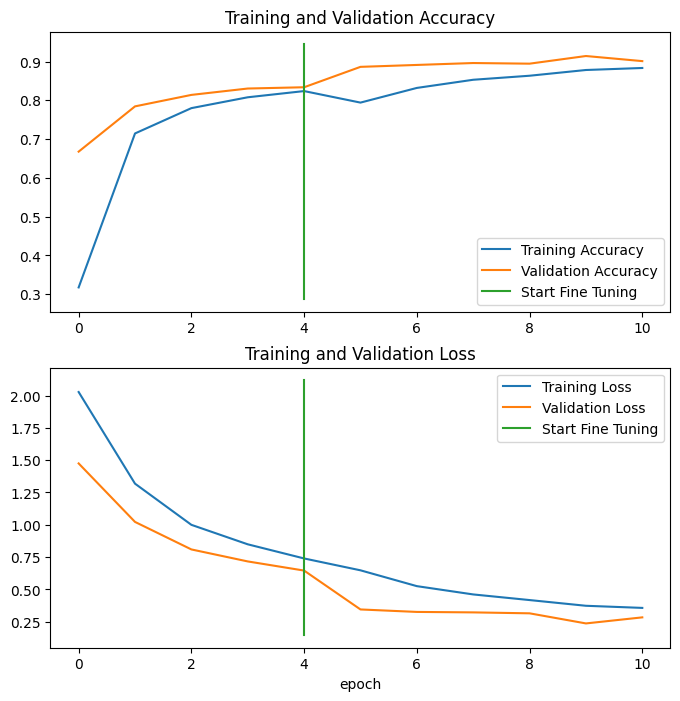

In [82]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

In [83]:
!tensorboard dev upload --logdir ./transfer_learning --name "Transfer learning experiments" --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" --one_shot

^C
